#Software Project

##Food Recognition – Burger, Pizza & Coke

------------------------------------------
- import dataset
- import modules


In [ ]:
!pip -q install gdown
!gdown https://drive.google.com/uc?id=1iETyQI2zdk0Q5Wgh5gnY2LXT6S4i6Zj0

Downloading...
From: https://drive.google.com/uc?id=1iETyQI2zdk0Q5Wgh5gnY2LXT6S4i6Zj0
To: /content/archive.zip
100% 339M/339M [00:01<00:00, 177MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('./archive.zip', 'r') as zip_ref:
  zip_ref.extractall('./')

In [ ]:
ls

archive.zip  sample_data/  train/  Training_set_food.csv


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import PIL
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import tensorboard

In [ ]:
tf.__version__

'2.7.0'

In [ ]:
df_old = pd.read_csv('Training_set_food.csv')
print(df_old)
print(df_old['label'].unique())
print(df_old.loc[[51]])
print(df_old[df_old['filename'] == 'Image_52.jpg'])

            filename       label
0        Image_1.jpg     burgers
1        Image_2.jpg     burgers
2        Image_3.jpg     burgers
3        Image_4.jpg     burgers
4        Image_5.jpg     burgers
...              ...         ...
5395  Image_5396.jpg  Softdrinks
5396  Image_5397.jpg  Softdrinks
5397  Image_5398.jpg  Softdrinks
5398  Image_5399.jpg  Softdrinks
5399  Image_5400.jpg  Softdrinks

[5400 rows x 2 columns]
['burgers' 'Pizza' 'Softdrinks']
        filename    label
51  Image_52.jpg  burgers
        filename    label
51  Image_52.jpg  burgers


In [ ]:
filter = [35,51,186,188,339,619,745,768,865,924,
       962,1000,1053,1123,1353,1382,1454,1460,
       1461,1478,1544,1603,1616,1804,2080,2138,
       2374,3887,4259,4267,4434,4703,4914,5024,
       5358,5385]
df_old.drop(filter, inplace=True)
df_old.reset_index(drop=True,inplace=True)

In [ ]:
df_old['label'].replace({'burgers': 0, 'Pizza': 1, 'Softdrinks': 2}, inplace=True)

In [ ]:
df_old.to_csv('food.csv', index=False)

In [ ]:
df = pd.read_csv('food.csv')
print(df)
print(df.loc[[51]])
print(len(df))

            filename  label
0        Image_1.jpg      0
1        Image_2.jpg      0
2        Image_3.jpg      0
3        Image_4.jpg      0
4        Image_5.jpg      0
...              ...    ...
5359  Image_5396.jpg      2
5360  Image_5397.jpg      2
5361  Image_5398.jpg      2
5362  Image_5399.jpg      2
5363  Image_5400.jpg      2

[5364 rows x 2 columns]
        filename  label
51  Image_54.jpg      0
5364


In [ ]:
for f in filter:
    fname = ('train/train/Image_'+ str(f+1) +'.jpg').encode('utf8')
    if os.path.isfile(fname):
        os.remove(fname)

#Data Preprocessing
-------------------

In [ ]:
def to_image(filename):
  image = cv2.imread('./train/train/' + str(filename))
  ratio = 240/max(image.shape[0],image.shape[1])
  width = int(image.shape[1] * ratio)
  height = int(image.shape[0] * ratio)
  dim = (width, height)
  new_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  top,bottom = int((240 - new_image.shape[0])/2), int((240 - new_image.shape[0])/2) + (1 if (new_image.shape[0]%2 != 0) else 0)
  left,right = int((240 - new_image.shape[1])/2), int((240 - new_image.shape[1])/2) + (1 if (new_image.shape[1]%2 != 0) else 0)
  new_image = cv2.copyMakeBorder(new_image, top, bottom, left, right, cv2.BORDER_CONSTANT, (0,0,0))
  new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
  return new_image

def to_image_with_aug(filename):
  image = cv2.imread('./train/train/' + str(filename))
  ratio = 240/max(image.shape[0],image.shape[1])
  width = int(image.shape[1] * ratio)
  height = int(image.shape[0] * ratio)
  dim = (width, height)
  new_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  top,bottom = int((240 - new_image.shape[0])/2), int((240 - new_image.shape[0])/2) + (1 if (new_image.shape[0]%2 != 0) else 0)
  left,right = int((240 - new_image.shape[1])/2), int((240 - new_image.shape[1])/2) + (1 if (new_image.shape[1]%2 != 0) else 0)
  new_image = cv2.copyMakeBorder(new_image, top, bottom, left, right, cv2.BORDER_CONSTANT, (0,0,0))
  new_image = cv2.normalize(new_image, None, 0, 255, cv2.NORM_MINMAX)
  new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
  new_image = tf.image.random_flip_left_right(new_image)
  new_image = tf.image.random_flip_up_down(new_image)
  return new_image


In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, batch_size):
        self.df = df.copy()
        self.n = len(self.df)
        self.filename = df['filename']
        self.label = df['label']
        self.batch_size = batch_size
    
    def __getitem__(self, idx):
        batch_x = self.filename[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.label[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([to_image(filename) for filename in batch_x]), np.array(batch_y)
    
    def __len__(self):
        return self.n // self.batch_size

In [ ]:
class CustomDataGen_with_aug(tf.keras.utils.Sequence):
    
    def __init__(self, df, batch_size):
        self.df = df.copy()
        self.n = len(self.df)
        self.filename = df['filename']
        self.label = df['label']
        self.batch_size = batch_size
    
    def __getitem__(self, idx):
        batch_x = self.filename[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.label[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([to_image_with_aug(filename) for filename in batch_x]), np.array(batch_y)
    
    def __len__(self):
        return self.n // self.batch_size

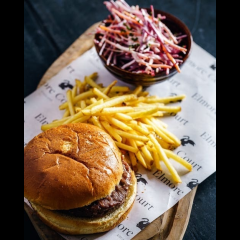

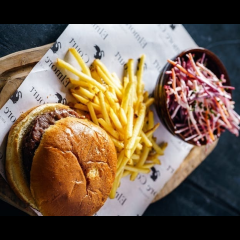

In [ ]:
h = to_image_with_aug('Image_45.jpg')
hh = to_image('Image_45.jpg')
hh = cv2.cvtColor(np.float32(hh), cv2.COLOR_RGB2BGR)
h = cv2.cvtColor(np.float32(h), cv2.COLOR_RGB2BGR)
cv2_imshow(hh)
cv2_imshow(h)
#k = cv2.imread('./train/train/Image_2.jpg')
#cv2_imshow(k)

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, train_size=0.8, random_state=4211, shuffle=True)
val_df, test_df = train_test_split(test_df, train_size=0.5, random_state=4211, shuffle=True)
train_data = CustomDataGen(train_df,100)
test_data = CustomDataGen(test_df,100)
val_data = CustomDataGen(val_df,100)

In [ ]:
model = tf.keras.applications.ResNet50(
    include_top=True,
    input_shape=(240,240,3),
    weights=None,
    classes=3
)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [ ]:
result = model.fit(train_data,validation_data=val_data,epochs=10)


Epoch 1/10
42/42 [==============================] - 126s 3s/step - loss: 1.1206 - accuracy: 0.6471 - val_loss: 543.2314 - val_accuracy: 0.3620
Epoch 2/10
42/42 [==============================] - 104s 2s/step - loss: 0.5966 - accuracy: 0.7776 - val_loss: 1.2365 - val_accuracy: 0.4720
Epoch 3/10
42/42 [==============================] - 104s 2s/step - loss: 0.4648 - accuracy: 0.8298 - val_loss: 2.9415 - val_accuracy: 0.3260
Epoch 4/10
42/42 [==============================] - 104s 2s/step - loss: 0.3927 - accuracy: 0.8526 - val_loss: 1.7065 - val_accuracy: 0.3980
Epoch 5/10
42/42 [==============================] - 104s 2s/step - loss: 0.3597 - accuracy: 0.8648 - val_loss: 3.3014 - val_accuracy: 0.3980
Epoch 6/10
42/42 [==============================] - 104s 2s/step - loss: 0.2979 - accuracy: 0.8883 - val_loss: 2.0460 - val_accuracy: 0.5440
Epoch 7/10
42/42 [==============================] - 104s 2s/step - loss: 0.2839 - accuracy: 0.8919 - val_loss: 0.4261 - val_accuracy: 0.8460
Epoch 8/10


In [ ]:
model.evaluate(test_data)

5/5 [==============================] - 5s 785ms/step - loss: 2.0460 - accuracy: 0.7980


[2.045968532562256, 0.7979999780654907]

tf.Tensor([[0.61585015 0.38208786 0.00206198]], shape=(1, 3), dtype=float32)


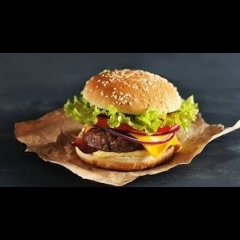

In [ ]:
from google.colab.patches import cv2_imshow
image = next(iter(test_data))[0][40]

print(model(np.expand_dims(image, axis=0)))

new_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2_imshow(new_image)

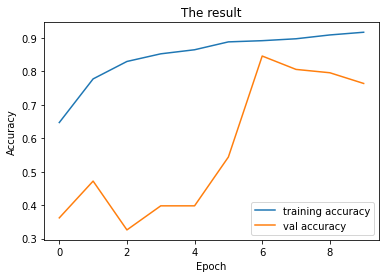

In [ ]:
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('The result')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

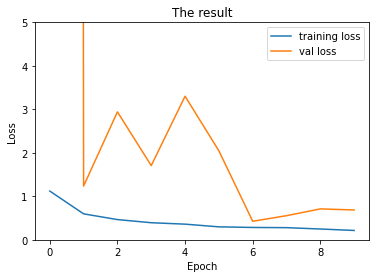

In [ ]:
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.ylim(0, 5)
plt.title('The result')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, train_size=0.8, random_state=4211, shuffle=True)
val_df, test_df= train_test_split(test_df, train_size=0.5, random_state=4211, shuffle=True)
train_data_with_aug = CustomDataGen_with_aug(train_df,100)
test_data = CustomDataGen(test_df,100)
val_data = CustomDataGen(val_df,100)

In [ ]:
model_with_aug = tf.keras.applications.ResNet50(
    include_top=True,
    input_shape=(240,240,3),
    weights=None,
    classes=3
)
model_with_aug.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [ ]:
result_with_aug = model_with_aug.fit(train_data_with_aug,validation_data=val_data,epochs=10)

Epoch 1/10
42/42 [==============================] - 146s 3s/step - loss: 1.1629 - accuracy: 0.6440 - val_loss: 1639.2627 - val_accuracy: 0.3320
Epoch 2/10
42/42 [==============================] - 137s 3s/step - loss: 0.5509 - accuracy: 0.7910 - val_loss: 1.2758 - val_accuracy: 0.5460
Epoch 3/10
42/42 [==============================] - 137s 3s/step - loss: 0.4766 - accuracy: 0.8193 - val_loss: 2.5328 - val_accuracy: 0.4700
Epoch 4/10
42/42 [==============================] - 138s 3s/step - loss: 0.4288 - accuracy: 0.8383 - val_loss: 2.7974 - val_accuracy: 0.4360
Epoch 5/10
42/42 [==============================] - 138s 3s/step - loss: 0.4009 - accuracy: 0.8476 - val_loss: 1.4885 - val_accuracy: 0.5700
Epoch 6/10
42/42 [==============================] - 137s 3s/step - loss: 0.3674 - accuracy: 0.8614 - val_loss: 1.3527 - val_accuracy: 0.6160
Epoch 7/10
42/42 [==============================] - 138s 3s/step - loss: 0.3549 - accuracy: 0.8652 - val_loss: 1.0192 - val_accuracy: 0.7280
Epoch 8/10

In [ ]:
model_with_aug.evaluate(test_data)

5/5 [==============================] - 5s 795ms/step - loss: 0.4622 - accuracy: 0.8560


[0.4621955454349518, 0.8560000061988831]

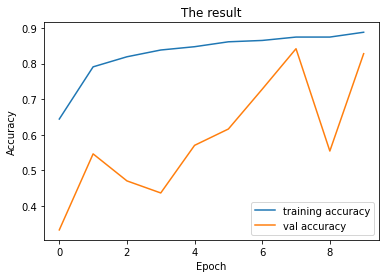

In [ ]:
plt.plot(result_with_aug.history['accuracy'], label='training accuracy')
plt.plot(result_with_aug.history['val_accuracy'], label='val accuracy')
plt.title('The result')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

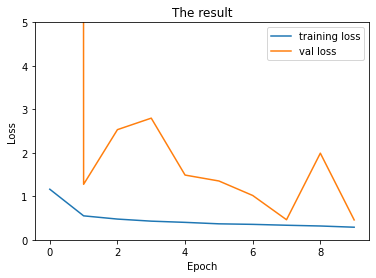

In [ ]:
plt.plot(result_with_aug.history['loss'], label='training loss')
plt.plot(result_with_aug.history['val_loss'], label='val loss')
plt.ylim(0, 5)
plt.title('The result')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

tf.Tensor([[2.2460259e-05 9.9993503e-01 4.2539479e-05]], shape=(1, 3), dtype=float32)


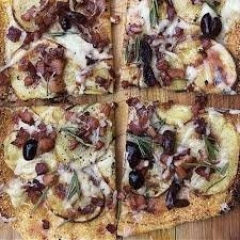

In [ ]:
image = next(iter(test_data))[0][34]

print(model_with_aug(np.expand_dims(image, axis=0)))

new_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2_imshow(new_image)

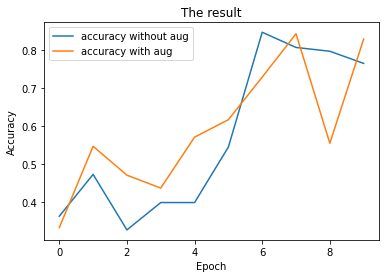

In [ ]:
plt.plot(result.history['val_accuracy'], label='val accuracy without aug')
plt.plot(result_with_aug.history['val_accuracy'], label='val accuracy with aug')
plt.title('The result')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

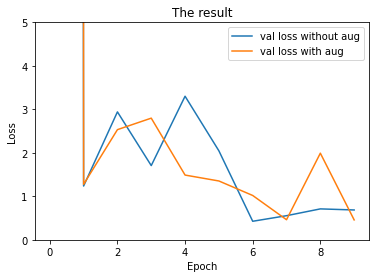

In [ ]:
plt.plot(result.history['val_loss'], label='val loss without aug')
plt.plot(result_with_aug.history['val_loss'], label='val loss with aug')
plt.ylim(0, 5)
plt.title('The result')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, train_size=0.8, random_state=4211, shuffle=True)
val_df, test_df= train_test_split(test_df, train_size=0.5, random_state=4211, shuffle=True)
train_data_with_aug = CustomDataGen_with_aug(train_df,50)
test_data = CustomDataGen(test_df,50)
val_data = CustomDataGen(val_df,50)

In [ ]:
model_with_xception = tf.keras.applications.xception.Xception(
    include_top=True,
    input_shape=(240,240,3),
    weights=None,
    classes=3
)
model_with_xception.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [ ]:
result_with_xception = model_with_xception.fit(train_data_with_aug,validation_data=val_data,epochs=10)

Epoch 1/10
85/85 [==============================] - 248s 3s/step - loss: 0.6776 - accuracy: 0.7226 - val_loss: 1.0981 - val_accuracy: 0.3560
Epoch 2/10
85/85 [==============================] - 236s 3s/step - loss: 0.4733 - accuracy: 0.8167 - val_loss: 1.0969 - val_accuracy: 0.3560
Epoch 3/10
85/85 [==============================] - 236s 3s/step - loss: 0.4005 - accuracy: 0.8482 - val_loss: 1.1012 - val_accuracy: 0.3560
Epoch 4/10
69/85 [=======================>......] - ETA: 43s - loss: 0.3606 - accuracy: 0.8542